# Import packages

In [2]:
!pip install -qU newsapi-python
!pip install -qU vaderSentiment
!pip install -qU yfinance

In [3]:
# !pip install black[jupyter]
## run source activate python3
## black Backtesting_Framework.ipynb in terminal

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABCMeta, abstractmethod
import requests
from pandas.tseries.offsets import BDay
from newsapi import NewsApiClient
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import boto3
from botocore.exceptions import ClientError
import json

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


# Dataloader

In [5]:
## Load from Alpaca
class DataLoader:
    def __init__(self, stock_client):
        self.stock_client = stock_client
        
    def fetch_historical_data(self, symbol, start_date=None, end_date=None):
        request_params = StockBarsRequest(
                                symbol_or_symbols=[symbol],
                                timeframe=TimeFrame.Day,
                                start=start_date
                        )
        bars = self.stock_client.get_stock_bars(request_params)
        bars_df = bars.df

        bars_df = (
            bars_df[['open', 'high', 'low', 'close', 'volume']]
            .reset_index().drop('symbol', axis=1)
        )

        bars = (
            bars_df
            .set_index(pd.to_datetime(bars_df['timestamp']))
            .rename(columns={
                'open': 'Open', 
                'high': 'High', 
                'low': 'Low', 
                'close': 'Close', 
                'volume': 'Volume'
                })
        )

        bars.index = bars.index.strftime('%Y-%m-%d')
        bars.index.name = 'Date'

        return bars

# Abstract classes

## Strategy

In [6]:
class Strategy(object):
    """Strategy is an abstract base class providing an interface for
    all subsequent (inherited) trading strategies.

    The goal of a (derived) Strategy object is to output a list of signals,
    which has the form of a time series indexed pandas DataFrame.

    In this instance only a single symbol/instrument is supported."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        """An implementation is required to return the DataFrame of symbols
        containing the signals to go long, short or hold (1, -1 or 0)."""
        raise NotImplementedError("Should implement generate_signals()!")

## Portfolio

In [7]:
class Portfolio(object):
    """An abstract base class representing a portfolio of
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

# Strategy subclasses

## Random Strategy

In [8]:
class RandomForecastingStrategy(Strategy):
    """Derives from Strategy to produce a set of signals that
    are randomly generated long/shorts. Clearly a nonsensical
    strategy, but perfectly acceptable for demonstrating the
    backtesting infrastructure!"""

    def __init__(self, symbol, bars):
        """Requires the symbol ticker and the pandas DataFrame of bars"""
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        """Creates a pandas DataFrame of random signals."""
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = np.sign(np.random.randn(len(signals)))

        # The first five elements are set to zero in order to minimise
        # upstream NaN errors in the forecaster.
        signals["signal"][0:5] = 0.0
        return signals

## MovingAverageCrossStrategy

In [289]:
class MovingAverageCrossStrategy(Strategy):
    def __init__(self, symbol, bars, short_window=2, long_window=5):
        self.symbol = symbol
        self.bars = bars
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = 0.0

        signals["short_mavg"] = (
            self.bars["Close"].rolling(self.short_window, min_periods=1).mean()
        )
        signals["long_mavg"] = (
            self.bars["Close"].rolling(self.long_window, min_periods=1).mean()
        )

        # print(signals['short_mavg'][self.short_window:].shift(1) < signals['long_mavg'][self.short_window:].shift(1))

        
        signals["signal"][self.short_window :] = np.where(
            (
                (
                    signals["short_mavg"][self.short_window :]
                    > signals["long_mavg"][self.short_window :]
                )
                & (
                    signals["short_mavg"][self.short_window :].shift(1)
                    < signals["long_mavg"][self.short_window :].shift(1)
                )
            ),
            1.0,
            0.0,
        )

        signals["signal"][self.short_window :] = np.where(
            (
                (
                    signals["short_mavg"][self.short_window :]
                    < signals["long_mavg"][self.short_window :]
                )
                & (
                    signals["short_mavg"][self.short_window :].shift(1)
                    > signals["long_mavg"][self.short_window :].shift(1)
                )
            ),
            -1.0,
            signals["signal"][self.short_window:],
        )

        # # signals['positions'] = signals['signal'].diff()
        # signals['positions'] = signals['signal'].cumsum()

        return signals

## Sentiment Analysis strategy

### TradingDateCalculator

In [10]:
class TradingDateCalculator:
    @staticmethod
    def get_trade_open(date):
        curr_date_open = pd.to_datetime(date).floor("d").replace(
            hour=13, minute=30
        ) - BDay(0)
        curr_date_close = pd.to_datetime(date).floor("d").replace(
            hour=20, minute=0
        ) - BDay(0)

        prev_date_close = (curr_date_open - BDay()).replace(hour=20, minute=0)
        next_date_open = (curr_date_close + BDay()).replace(hour=13, minute=30)

        if (pd.to_datetime(date) >= prev_date_close) & (
            pd.to_datetime(date) < curr_date_open
        ):
            return curr_date_open
        elif (pd.to_datetime(date) >= curr_date_close) & (
            pd.to_datetime(date) < next_date_open
        ):
            return next_date_open
        else:
            return None


class NewsLoader:
    def __init__(self, news_api_key):
        self.news_api_key = news_api_key
        self.url = "https://newsapi.org/v2/everything?"

    def load_news(self, symbol, pageSize=100):  # Timeframe,
        parameters = {
            "q": symbol,
            "sortBy": "popularity",
            "pageSize": pageSize,
            "apiKey": self.news_api_key,
        }

        response = requests.get(self.url, params=parameters)
        data = pd.DataFrame(response.json())

        # Transformation to data for use
        news_df = pd.concat([data["articles"].apply(pd.Series)], axis=1)

        # This is sentiment analysi regarding to headlines
        final_news = news_df[["publishedAt", "title"]].copy(deep=True)
        final_news["publishedAt"] = pd.to_datetime(final_news["publishedAt"])
        final_news = final_news.sort_values(by="publishedAt").reset_index(drop=True)

        # Change according to business day
        final_news.loc[:, "trading_time"] = final_news["publishedAt"].apply(
            TradingDateCalculator.get_trade_open
        )  # def get_trade_open(date):
        final_news = final_news[final_news["trading_time"].notnull()].copy()
        final_news.loc[:, "Date"] = pd.to_datetime(final_news["trading_time"]).dt.date
        final_news = final_news.drop(labels=["publishedAt", "trading_time"], axis=1)

        return final_news

### SentimentAnalysis

In [11]:
class SentimentAnalyzer:
    def __init__(self):
        self.sentiment_analyzer = SentimentIntensityAnalyzer()

    def score_each_article(self, final_news):
        cs = []
        for idx, row in final_news.iterrows():
            cs.append(self.sentiment_analyzer.polarity_scores(row["title"])["compound"])

        final_news.loc[:, "compound_vader_score"] = cs
        article_score = final_news[
            (final_news[["compound_vader_score"]] != 0).all(axis=1)
        ].reset_index(drop=True)

        return article_score

    def daily_compound_sentiment_score(self, final_news):
        """
        Input: DataFrame; |publishedAt|title|
        Output: DataFrame; |Date|Score|
        """
        article_score = self.score_each_article(final_news)

        # Get unique dates
        unique_dates = article_score["Date"].unique()
        grouped_dates = article_score.groupby(["Date"])
        keys_dates = list(grouped_dates.groups.keys())

        # get max/min score daily
        max_cs = []
        min_cs = []

        for key in keys_dates:
            data = grouped_dates.get_group(key)
            if data["compound_vader_score"].max() > 0:
                max_cs.append(data["compound_vader_score"].max())
            elif data["compound_vader_score"].max() < 0:
                max_cs.append(0)

            if data["compound_vader_score"].min() < 0:
                min_cs.append(data["compound_vader_score"].min())
            elif data["compound_vader_score"].min() > 0:
                min_cs.append(0)

        # figure compound socre
        extreme_scores_dict = {
            "Date": keys_dates,
            "max_scores": max_cs,
            "min_scores": min_cs,
        }
        extreme_scores_df = pd.DataFrame(extreme_scores_dict)

        final_scores = []
        for i in range(len(extreme_scores_df)):
            final_scores.append(
                extreme_scores_df["max_scores"][i] + extreme_scores_df["min_scores"][i]
            )

        daily_score = pd.DataFrame({"Date": keys_dates, "Score": final_scores})

        return daily_score

In [12]:
class NewsSentimentAnalysis:
    def __init__(self, news_api_key):
        self.news_loader = NewsLoader(news_api_key)
        self.sentiment_analyzer = SentimentAnalyzer()

    def analyze_sentiment(self, symbol, pageSize=100):
        final_news = self.news_loader.load_news(symbol, pageSize)
        return self.sentiment_analyzer.daily_compound_sentiment_score(final_news)

### SentimentAnalysis Strategy

In [13]:
class SentimentAnalysisStrategy(Strategy):
    def __init__(self, symbol, bars, threshold, news_api_key):
        self.symbol = symbol
        self.bars = bars
        self.threshold = threshold  # 0.2
        self.news_loader = NewsLoader(news_api_key)
        self.sentiment_analyzer = SentimentAnalyzer()

    def generate_news_signals(self):
        score_df = self.sentiment_analyzer.daily_compound_sentiment_score(
            self.news_loader.load_news(self.symbol)
        )

        vader_Buy, vader_Sell = [], []
        for i in range(len(score_df)):
            if score_df["Score"].values[i] > self.threshold:
                # print(f"Trade Call for {extreme_scores_df['Date'][i]} is Buy.")
                vader_Buy.append(score_df["Date"][i])
            elif score_df["Score"].values[i] < -self.threshold:
                # print(f"Trade Call for {extreme_scores_df['Date'][i]} is Sell.")
                vader_Sell.append(score_df["Date"][i])
        return vader_Buy, vader_Sell

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = 0.0

        vader_Buy, vader_Sell = self.generate_news_signals()

        for i in range(len(self.bars)):
            if self.bars.index[i].date() in vader_Buy:
                signals.iloc[i, :] = 1.0

        for i in range(len(self.bars)):
            if self.bars.index[i].date() in vader_Sell:
                signals.iloc[i, :] = -1.0

        return signals

## Logistic Regression

In [152]:
class LogisticRegressionStrategy(Strategy):
    def __init__(self, threshold, symbol, full_bars, model):
        self.symbol = symbol
        self.bars = full_bars
        self.threshold = threshold
        self.model = model
    
    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        # signals["signal"] = 0.0
        
        ss = MinMaxScaler()
        scaled_bars = ss.fit_transform(self.bars)
        pred_prob = self.model.predict_proba(np.array(scaled_bars))
        signals["signal"] = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > self.threshold else 0, axis=1).tolist()
        
        return signals

In [153]:
# load the model from disk
clf_pred = pickle.load(open(filename, 'rb'))

In [154]:
pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.527 else 0, axis=1).value_counts()

1    2169
0       3
Name: count, dtype: int64

In [155]:
signals = pd.DataFrame(index=full_data.index)
# signals["signal"] = 0.0

ss = MinMaxScaler()
scaled_bars = ss.fit_transform(full_data)
pred_prob = clf_pred.predict_proba(np.array(scaled_bars))
signals["signal"] = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.527 else 0, axis=1).tolist()

signals

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [141]:
returns

,holdings,cash,total,returns
Date,,,,
2016-01-04,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN
2016-01-07,243.0,NaN,NaN,NaN
2016-01-08,472.0,99764.00,100236.00,NaN
...,...,...,...,...
2024-08-19,32135095.0,-13149397.27,18985697.73,0.032116
2024-08-20,33895734.0,-13165046.27,20730687.73,0.091911
2024-08-21,33831204.0,-13180658.27,20650545.73,-0.003866


# ML strategies exploration

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [20]:
symbol = 'AMD'
api_key = "PK6IRONYS5AQ646ZTDKX"
api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
client = StockHistoricalDataClient(api_key, api_secret)

start_date = "2014-01-01 00:00:00"

data_loader = DataLoader(client)
bars = data_loader.fetch_historical_data(symbol, start_date=start_date)

In [21]:
bars

,timestamp,Open,High,Low,Close,Volume
Date,,,,,,
2016-01-04,2016-01-04 05:00:00+00:00,2.77,2.820,2.63,2.770,33698464.0
2016-01-05,2016-01-05 05:00:00+00:00,2.77,2.800,2.64,2.750,13372522.0
2016-01-06,2016-01-06 05:00:00+00:00,2.66,2.710,2.47,2.505,24280750.0
2016-01-07,2016-01-07 05:00:00+00:00,2.43,2.480,2.26,2.275,22577907.0
2016-01-08,2016-01-08 05:00:00+00:00,2.36,2.425,2.10,2.140,34037306.0
...,...,...,...,...,...,...
2024-08-19,2024-08-19 04:00:00+00:00,148.43,155.365,147.72,155.280,60766854.0
2024-08-20,2024-08-20 04:00:00+00:00,156.49,162.040,154.51,156.400,76851158.0
2024-08-21,2024-08-21 04:00:00+00:00,156.12,158.650,155.07,157.810,42791246.0


In [22]:
bars_cls = bars
delta = 0.01
bars_cls['Signal'] = [int(row['High'] >= (1 + delta) * row['Open']) for idx, row in bars_cls.iterrows()]
print(bars_cls.Signal.value_counts())
bars_cls.head(10)

Signal
1    1430
0     745
Name: count, dtype: int64


,timestamp,Open,High,Low,Close,Volume,Signal
Date,,,,,,,
2016-01-04,2016-01-04 05:00:00+00:00,2.77,2.820,2.63,2.770,33698464.0,1
2016-01-05,2016-01-05 05:00:00+00:00,2.77,2.800,2.64,2.750,13372522.0,1
2016-01-06,2016-01-06 05:00:00+00:00,2.66,2.710,2.47,2.505,24280750.0,1
2016-01-07,2016-01-07 05:00:00+00:00,2.43,2.480,2.26,2.275,22577907.0,1
2016-01-08,2016-01-08 05:00:00+00:00,2.36,2.425,2.10,2.140,34037306.0,1
2016-01-11,2016-01-11 05:00:00+00:00,2.16,2.360,2.12,2.340,20210936.0,1
2016-01-12,2016-01-12 05:00:00+00:00,2.40,2.460,2.28,2.390,18704579.0,1
2016-01-13,2016-01-13 05:00:00+00:00,2.40,2.450,2.21,2.250,13427196.0,1
2016-01-14,2016-01-14 05:00:00+00:00,2.29,2.350,2.21,2.210,16790302.0,1


In [23]:
period = 3

full_data = pd.DataFrame()

full_data.index = bars_cls.index

for i in range(1, period + 1):
    for feature in ['Open','High','Low','Close','Volume']: # ['Close','Volume']:
        full_data[f'{feature}_-{i}'] = bars_cls[feature].shift(i)

full_data['Signal_next'] = bars_cls['Signal'].shift(-1)

# full_data.dropna(inplace=True)
full_data.head()

,Open_-1,High_-1,Low_-1,Close_-1,Volume_-1,Open_-2,High_-2,Low_-2,Close_-2,Volume_-2,Open_-3,High_-3,Low_-3,Close_-3,Volume_-3,Signal_next
Date,,,,,,,,,,,,,,,,
2016-01-07,2.66,2.710,2.47,2.505,24280750.0,2.77,2.800,2.64,2.750,13372522.0,2.77,2.820,2.63,2.770,33698464.0,1.0
2016-01-08,2.43,2.480,2.26,2.275,22577907.0,2.66,2.710,2.47,2.505,24280750.0,2.77,2.800,2.64,2.750,13372522.0,1.0
2016-01-11,2.36,2.425,2.10,2.140,34037306.0,2.43,2.480,2.26,2.275,22577907.0,2.66,2.710,2.47,2.505,24280750.0,1.0
2016-01-12,2.16,2.360,2.12,2.340,20210936.0,2.36,2.425,2.10,2.140,34037306.0,2.43,2.480,2.26,2.275,22577907.0,1.0
2016-01-13,2.40,2.460,2.28,2.390,18704579.0,2.16,2.360,2.12,2.340,20210936.0,2.36,2.425,2.10,2.140,34037306.0,1.0


In [24]:
X = full_data.drop(columns = ['Signal_next'])
y = full_data["Signal_next"]

# train_test_split 
dev_test_split = int(0.8*X.shape[0])
X_dev_df, X_test_df, y_dev_df, y_test_df= X.iloc[:dev_test_split], X.iloc[dev_test_split:], y.iloc[:dev_test_split], y.iloc[dev_test_split:]


train_val_split = int(0.75*X_dev_df.shape[0])
X_train_df, X_val_df, y_train_df, y_val_df = X_dev_df.iloc[:train_val_split], X_dev_df.iloc[train_val_split:], y_dev_df.iloc[:train_val_split], y_dev_df.iloc[train_val_split:]
                      

In [25]:
ss = MinMaxScaler()
X_train_scaled = ss.fit_transform(X_train_df)
X_val_scaled = ss.transform(X_val_df)
X_test_scaled = ss.transform(X_test_df)

In [ ]:
def get_report(y_pred, y_test):
    """
    function to Report the first 3 and last 3 predictions on X_test,
    along with the actual labels in y_test.
    
    Returns a dataframe with 6 rows.
    """
    preds = np.concatenate([y_pred[:3], y_pred[-3:]])
    actuals = np.concatenate([y_test[:3], y_test[-3:]])
    df_compare = pd.DataFrame({'Prediction': preds,
                               'Actual':actuals})
    df_compare['Position'] = [1, 2, 3, len(y_pred) - 2, len(y_pred) - 1, len(y_pred)]
    df_compare = df_compare.set_index('Position')
    return df_compare

In [34]:
X_train_scaled.shape

(1302, 15)

In [ ]:
lgr.predict(X_train_scaled).shape

In [75]:
clf = LogisticRegression(random_state=42).fit(X_train_scaled, y_train_df)
pred_prob = clf.predict_proba(X_train_scaled)

In [93]:
np.linspace(0.5, 0.7, num=100)

array([0.5       , 0.5020202 , 0.5040404 , 0.50606061, 0.50808081,
       0.51010101, 0.51212121, 0.51414141, 0.51616162, 0.51818182,
       0.52020202, 0.52222222, 0.52424242, 0.52626263, 0.52828283,
       0.53030303, 0.53232323, 0.53434343, 0.53636364, 0.53838384,
       0.54040404, 0.54242424, 0.54444444, 0.54646465, 0.54848485,
       0.55050505, 0.55252525, 0.55454545, 0.55656566, 0.55858586,
       0.56060606, 0.56262626, 0.56464646, 0.56666667, 0.56868687,
       0.57070707, 0.57272727, 0.57474747, 0.57676768, 0.57878788,
       0.58080808, 0.58282828, 0.58484848, 0.58686869, 0.58888889,
       0.59090909, 0.59292929, 0.59494949, 0.5969697 , 0.5989899 ,
       0.6010101 , 0.6030303 , 0.60505051, 0.60707071, 0.60909091,
       0.61111111, 0.61313131, 0.61515152, 0.61717172, 0.61919192,
       0.62121212, 0.62323232, 0.62525253, 0.62727273, 0.62929293,
       0.63131313, 0.63333333, 0.63535354, 0.63737374, 0.63939394,
       0.64141414, 0.64343434, 0.64545455, 0.64747475, 0.64949

In [107]:
import pickle

In [108]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [104]:
threshold = np.linspace(0.4, 0.7, num=100)[res.index(max(res))]

0.5272727272727272

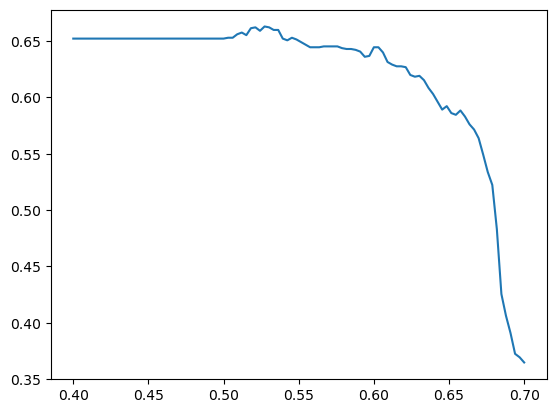

In [97]:
res = []
for i in np.linspace(0.4, 0.7, num=100):
    pred = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > i else 0, axis=1)
#     conf_matrix = confusion_matrix(pred, y_train_df)

#     TP = conf_matrix[1, 1]
#     TN = conf_matrix[0, 0]
#     FP = conf_matrix[0, 1]
#     FN = conf_matrix[1, 0]
    
#     print((TP + TN) / sum(map(sum, conf_matrix)))
#     print(accuracy_score(y_train_df, pred))
    res.append(accuracy_score(y_train_df, pred))

fig = plt.figure()
ax = plt.axes()
ax.plot(np.linspace(0.4, 0.7, num=100), res)

In [88]:
pred = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.59 else 0, axis=1)
pred

0       1
1       1
2       1
3       1
4       1
       ..
1297    0
1298    0
1299    0
1300    0
1301    0
Length: 1302, dtype: int64

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [89]:
conf_matrix = confusion_matrix(pred, y_train_df)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

In [90]:
# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division
print((TP + TN) / sum(map(sum, conf_matrix)))
print(accuracy_score(y_train_df, pred))

0.641321044546851
0.641321044546851


Text(0.5, 1.0, 'Training Loss over Epochs')

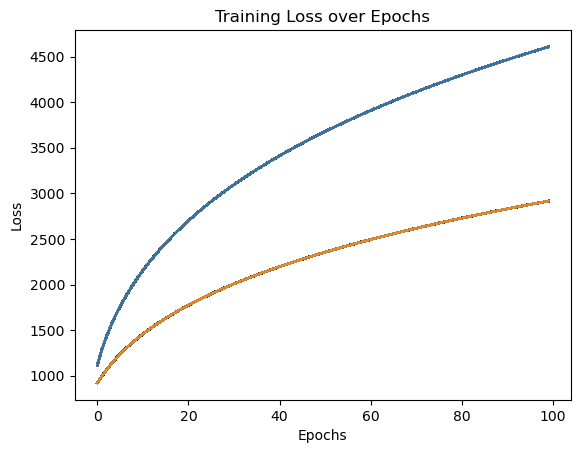

In [218]:
### Code here
lgr = LogisticRegression(alpha=0, t=100, eta=1e-3)
loss_train = lgr.train(X_train_scaled, np.array(y_train_df.tolist()))

loss_train = np.squeeze(loss_train)

fig, ax = plt.subplots()
ax.plot(range(100), loss_train)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss over Epochs')

In [193]:
### Code here
lr = LinearRegression()
lr.train(X_train_scaled, y_train_df)

# predictions
y_pred_train = lr.predict(X_train_scaled)
y_pred_val = lr.predict(X_val_scaled)
y_pred_test = lr.predict(X_test_scaled)

# Export R^2
r2_train = r2_score(y_pred_train, y_train_df)
r2_val = r2_score(y_pred_val, y_val_df)
r2_test = r2_score(y_pred_test, y_test_df)
print(f"R^2 score on training set: {r2_train}")
print(f"R^2 score on training set: {r2_val}")
print(f"R^2 score on training set: {r2_test}")

# Get report
get_report(y_pred_train, y_train_df)
get_report(y_pred_val, y_val_df)
get_report(y_pred_test, y_test_df)

R^2 score on training set: -40.453142294372896
R^2 score on training set: -9.643044769320358
R^2 score on training set: -8.715021056768009


,Prediction,Actual
Position,,
1,0.529807,1.0
2,0.469366,1.0
3,0.595664,1.0
433,0.694597,1.0
434,0.637498,0.0
435,0.297701,1.0


# Portfolio

In [119]:
class MarketOnClosePortfolio(Portfolio):
    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()

    def generate_positions(self):
        positions = pd.DataFrame(index=self.bars.index).fillna(0.0)
        positions[self.symbol] = 100 * self.signals["signal"]
        return positions.cumsum()

    def backtest_portfolio(self):
        # portfolio = pd.DataFrame({'pos_value': self.positions[self.symbol] * self.bars['Close']})

        # pos_diff = self.positions.diff()

        # portfolio['holdings'] = self.positions[self.symbol] * self.bars['Close']
        # portfolio['cash'] = self.initial_capital - (pos_diff[self.symbol] * self.bars['Close']).cumsum()

        # portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        # portfolio['returns'] = portfolio['total'].pct_change()

        portfolio = pd.DataFrame(index=self.bars.index)
        portfolio["holdings"] = self.positions[self.symbol] * self.bars["Close"]
        pos_diff = self.positions.diff()
        portfolio["cash"] = (
            self.initial_capital - (pos_diff[self.symbol] * self.bars["Close"]).cumsum()
        )
        portfolio["total"] = portfolio["cash"] + portfolio["holdings"]
        portfolio["returns"] = portfolio["total"].pct_change()

        return portfolio

In [397]:
class MarketOnOpenPortfolio(Portfolio):
    """Inherits Portfolio to create a system that purchases 100 units of
    a particular symbol upon a long/short signal, assuming the market
    open price of a bar.

    In addition, there are zero transaction costs and cash can be immediately
    borrowed for shorting (no margin posting or interest requirements).

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, risk_ratio=0.05, stop_loss_percent=0.1, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        # self.cash = self.initial_capital
        self.risk_ratio = risk_ratio
        self.stop_loss_percent = stop_loss_percent
        self.positions = self.generate_positions()
    
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index, columns=[self.symbol])
        positions[self.symbol] = positions[self.symbol].mask(pd.isna(positions[self.symbol]), 0)
        equity = [self.initial_capital] # length n
        
        for i in range(1, len(self.signals)):
            signal = self.signals['signal'].iloc[i]
            open_price = self.bars["Open"].iloc[i]
            prev_open_price = self.bars["Open"].iloc[i-1]

#             historical = [abs(j - self.initial_capital) for j in equity[:i]]
#             if max(historical) != 0:
#                 trade_risk = max(historical)
#             else:
#                 trade_risk = open_price

#             num_of_contract = int(equity[i-1] * self.risk_ratio / trade_risk)
            num_of_contract = int(equity[i-1] * self.risk_ratio / (open_price * self.stop_loss_percent))
            
            

            if signal == 1:
                positions.iloc[i] = num_of_contract
            elif signal == -1:
                positions.iloc[i] = 0
            else:
                positions.iloc[i] = positions.iloc[i-1]

            pnl = float(positions.iloc[i-1].values) * (open_price - prev_open_price)
            equity.append(equity[i-1] + pnl)

        return positions
    
    
    def backtest_portfolio(self):
        """Constructs a portfolio from the positions DataFrame by
        assuming the ability to trade at the precise market open price
        of each bar (an unrealistic assumption!).

        Calculates the total of cash and the holdings (market price of
        each position per bar), in order to generate an equity curve
        ('total') and a set of bar-based returns ('returns').

        Returns the portfolio object to be used elsewhere."""
    
        portfolio = pd.DataFrame(index=self.bars.index)
        portfolio["holdings"] = self.positions[self.symbol] * self.bars["Open"]
        pos_diff = self.positions.diff()
        portfolio["cash"] = (
            self.initial_capital - (pos_diff[self.symbol] * self.bars["Open"]).cumsum()
        )
        portfolio["equity"] = portfolio["cash"] + portfolio["holdings"]
        portfolio["returns"] = portfolio["equity"].pct_change()
        print(self.risk_ratio)

        return portfolio

In [336]:
signals

,signal,short_mavg,long_mavg
Date,,,
2016-01-04,0.0,2.770000,2.770000
2016-01-05,0.0,2.760000,2.760000
2016-01-06,0.0,2.675000,2.675000
2016-01-07,0.0,2.575000,2.575000
2016-01-08,0.0,2.488000,2.488000
...,...,...,...
2024-08-20,0.0,156.777950,128.448688
2024-08-21,0.0,157.027850,128.666888
2024-08-22,0.0,157.225100,128.876863


In [209]:
initial_capital = 100000
symbol = 'AMD'
positions = pd.DataFrame(index=signals.index, columns=[symbol])
positions[symbol] = positions[symbol].mask(pd.isna(positions[symbol]), 0)
equity = [initial_capital] # length n
risk_ratio = 0.05

for i in range(1, len(signals)):
    signal = signals['signal'].iloc[i]
    open_price = bars["Open"].iloc[i]
    prev_open_price = bars["Open"].iloc[i-1]

    historical = [abs(i - initial_capital) for i in equity[:i]]
    if max(historical) != 0:
        trade_risk = max(historical)
    else:
        trade_risk = open_price
    
    num_of_contract = int(equity[i-1] * risk_ratio / trade_risk)

    if signal != 0:
        positions.iloc[i] = num_of_contract

    else:
        positions.iloc[i] = positions.iloc[i-1]

    pnl = positions.iloc[i-1] * (open_price - prev_open_price)
    equity.append(equity[i-1] + pnl)

return positions

/tmp/ipykernel_9001/3257929084.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  positions = pd.DataFrame(index=signals.index, columns=[symbol]).fillna(0.0)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [280]:
initial_capital = 100000
symbol = 'AMD'
positions = pd.DataFrame(index=signals.index, columns=[symbol])
positions[symbol] = positions[symbol].mask(pd.isna(positions[symbol]), 0)
equity = [initial_capital] # length n
risk_ratio = 0.05

In [283]:
i = 2
signal = signals['signal'].iloc[i]
open_price = bars["Open"].iloc[i]
prev_open_price = bars["Open"].iloc[i-1]

historical = [abs(i - initial_capital) for i in equity[:i]]
if max(historical) != 0:
    trade_risk = max(historical)
else:
    trade_risk = open_price

num_of_contract = int(equity[i-1] * risk_ratio / trade_risk)

if signal != 0:
    positions.iloc[i] = num_of_contract

else:
    positions.iloc[i] = positions.iloc[i-1]

pnl = float(positions.iloc[i-1].values) * (open_price - prev_open_price)
equity.append(equity[i-1] + pnl)

In [286]:
signals['signal'].value_counts()

signal
 0.0    2172
-1.0       2
 1.0       2
Name: count, dtype: int64

# Execution

## Random Strategy Execution

In [13]:
if __name__ == "__main__":
    # Obtain daily bars of SPY (ETF that generally
    # follows the S&P500) from Quandl (requires 'pip install Quandl'
    # on the command line)

    # Fetch SPY data
    symbol = "SPY"
    bars = yf.download(symbol, period="2y")  # start='2024-05-01'
    bars.index = bars.index.date

    # Create a set of random forecasting signals for SPY
    rfs = RandomForecastingStrategy(symbol, bars)
    signals = rfs.generate_signals()

    # Create a portfolio of SPY
    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()

## Sentiment Analysis Execution

[*********************100%%**********************]  1 of 1 completed


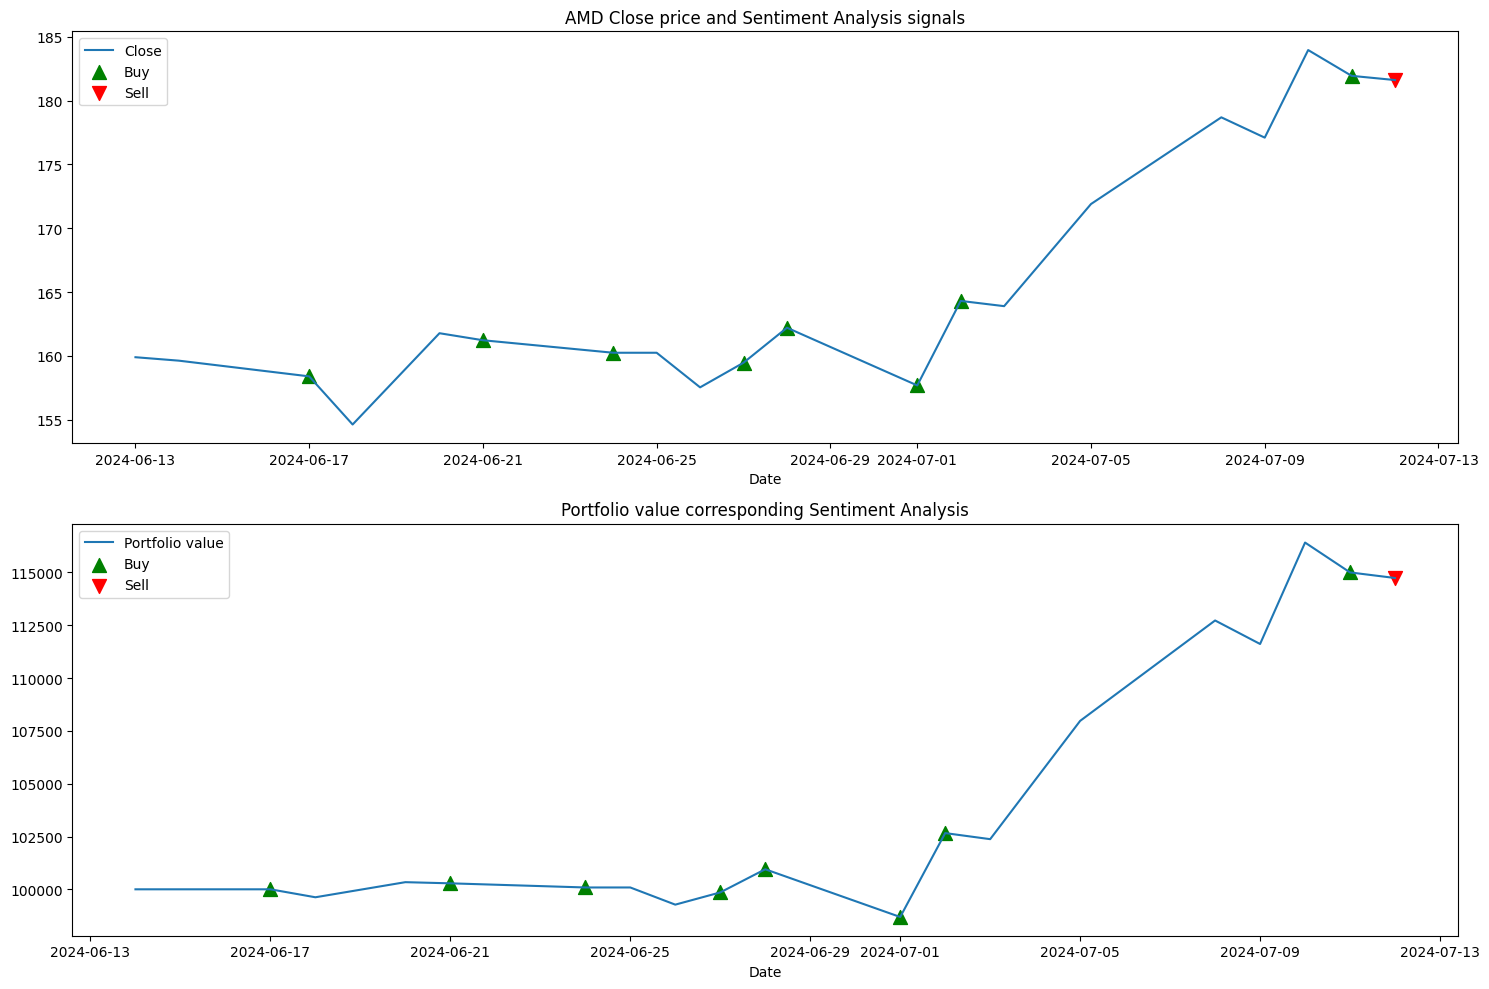

In [51]:
if __name__ == "__main__":
    symbol = "AMD"
    bars = yf.download(tickers=symbol, period="1mo")
    threshold = 0.2
    news_api_key = userdata.get("news_api_key")

    senti_analysis = SentimentAnalysisStrategy(symbol, bars, threshold, news_api_key)
    signals = senti_analysis.generate_signals()

    portfolio = MarketOnClosePortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()

    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"], label="Close")
    ax[0].scatter(
        bars["Close"][signals["signal"] == 1.0].index,
        bars["Close"][signals["signal"] == 1.0].values,
        100,
        c="green",
        marker="^",
        label="Buy",
    )
    ax[0].scatter(
        bars["Close"][signals["signal"] == -1.0].index,
        bars["Close"][signals["signal"] == -1.0].values,
        100,
        c="red",
        marker="v",
        label="Sell",
    )

    ax[0].legend()
    ax[0].set_title(f"{symbol} Close price and Sentiment Analysis signals")
    ax[0].set_xlabel("Date")

    ax[1].plot(returns["total"], label="Portfolio value")
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["total"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
        label="Buy",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["total"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
        label="Sell",
    )

    ax[1].legend()
    ax[1].set_title(f"Portfolio value corresponding Sentiment Analysis")
    ax[1].set_xlabel("Date")

## Moving Average Crossovers Strategy Execution

In [18]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical import StockHistoricalDataClient # Create stock historical data client

/tmp/ipykernel_9001/2782439365.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals["signal"][self.short_window :] = np.where(
/tmp/ipykernel_9001/966422173.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .b

0.05


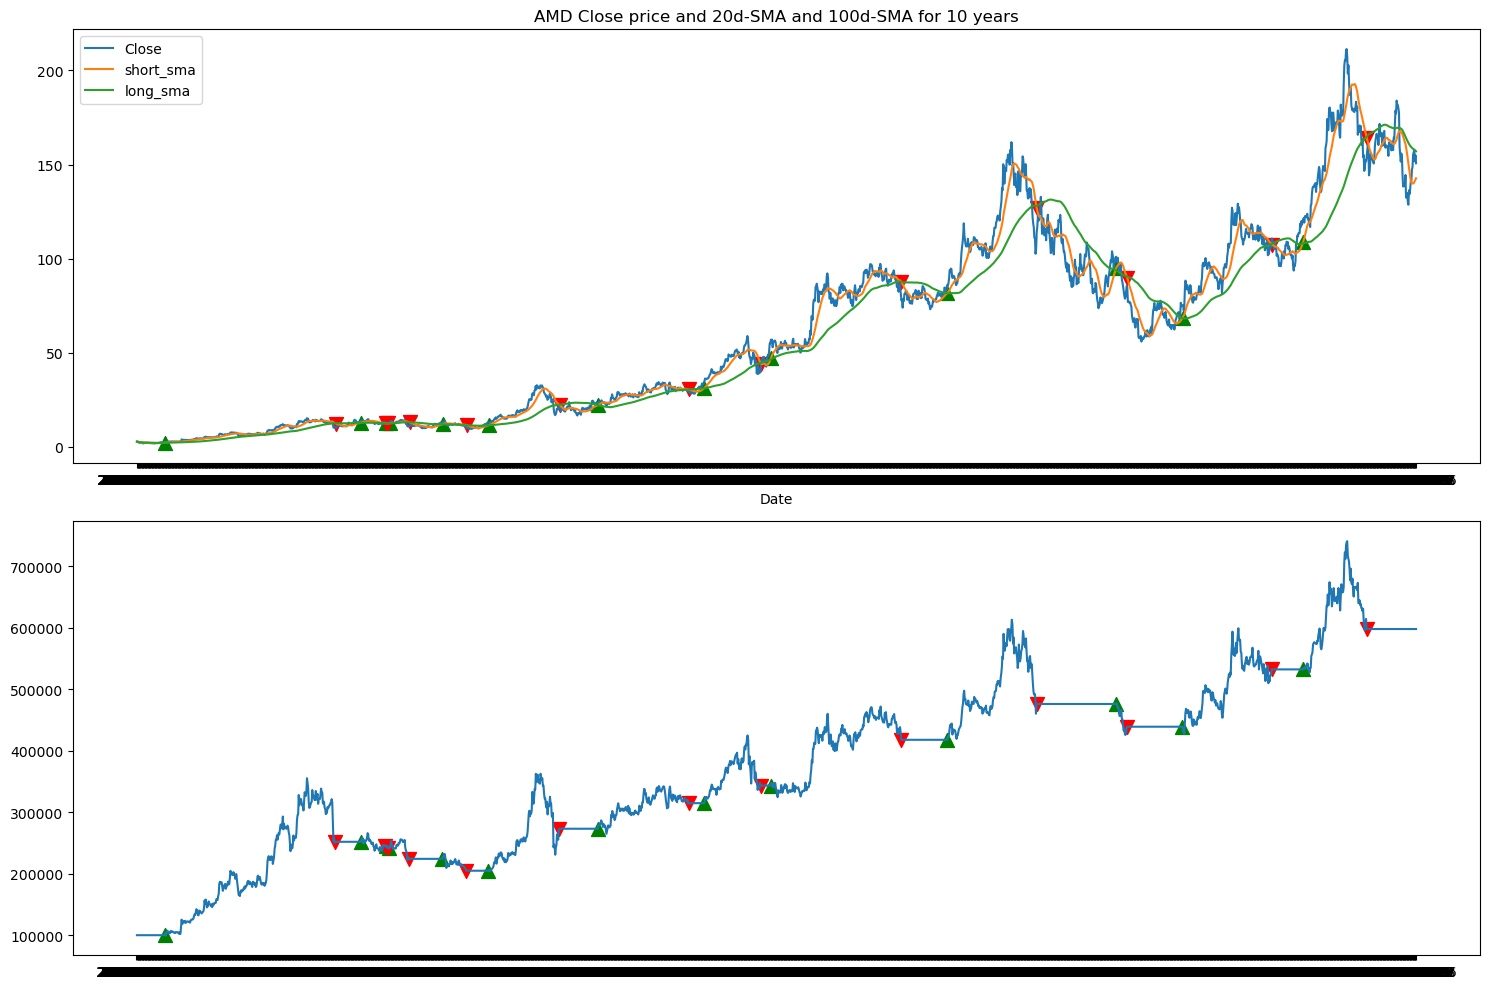

In [399]:
if __name__ == "__main__":
    symbol = "AMD"
    
    # Load data
    # bars = yf.download(tickers=symbol, period="10y")
    api_key = "PK6IRONYS5AQ646ZTDKX"
    api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
    client = StockHistoricalDataClient(api_key, api_secret)
    request_params = StockBarsRequest(
                            symbol_or_symbols=[symbol],
                            timeframe=TimeFrame.Day,
                            start="2014-01-01 00:00:00"
                     )
    bars = client.get_stock_bars(request_params)
    bars_df = bars.df

    bars_df = (
        bars_df[['open', 'high', 'low', 'close', 'volume']]
        .reset_index().drop('symbol', axis=1)
    )

    bars = (
        bars_df
        .set_index(pd.to_datetime(bars_df['timestamp']))
        .rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
    )

    bars.index = bars.index.strftime('%Y-%m-%d')
    bars.index.name = 'Date'
    
    
    
    short_window, long_window = 20, 100

    mac = MovingAverageCrossStrategy(
        symbol, bars, short_window=short_window, long_window=long_window
    )
    signals = mac.generate_signals()

    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, risk_ratio=0.05, stop_loss_percent=0.1, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()
    
    # backtesting results
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"], label="Close")
    ax[0].plot(signals[["short_mavg", "long_mavg"]], label=["short_sma", "long_sma"])
    ax[0].scatter(
        signals[signals["signal"] == 1.0].index,
        signals["short_mavg"][signals["signal"] == 1.0],
        100,
        c="green",
        marker="^",
    )
    ax[0].scatter(
        signals[signals["signal"] == -1.0].index,
        signals["short_mavg"][signals["signal"] == -1.0],
        100,
        c="red",
        marker="v",
    )
    ax[0].legend()
    ax[0].set_title(
        f"{symbol} Close price and {short_window}d-SMA and {long_window}d-SMA for 10 years"
    )
    ax[0].set_xlabel("Date")

    ax[1].plot(returns["equity"])
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["equity"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["equity"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
    )

In [380]:
portfolio.positions

,AMD
Date,
2016-01-04,0
2016-01-05,0
2016-01-06,0
2016-01-07,0
2016-01-08,0
...,...
2024-08-20,0
2024-08-21,0
2024-08-22,0


In [381]:
portfolio.positions['AMD'].value_counts()

AMD
0       1771
1766     405
Name: count, dtype: int64

In [391]:
portfolio.positions['AMD'].loc['2017-11-07']

1766

In [387]:
signals['signal'][signals['signal'] == -1]

Date
2017-11-08   -1.0
2021-04-21   -1.0
2022-03-28   -1.0
2024-08-14   -1.0
Name: signal, dtype: float64

In [385]:
returns['holdings']

Date
2016-01-04    0.0
2016-01-05    0.0
2016-01-06    0.0
2016-01-07    0.0
2016-01-08    0.0
             ... 
2024-08-20    0.0
2024-08-21    0.0
2024-08-22    0.0
2024-08-23    0.0
2024-08-26    0.0
Name: holdings, Length: 2176, dtype: object

## Logistic Regression execution

In [179]:
if __name__ == "__main__":
    symbol = "AMD"
    
    # Load data
    # bars = yf.download(tickers=symbol, period="10y")
    api_key = "PK6IRONYS5AQ646ZTDKX"
    api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
    client = StockHistoricalDataClient(api_key, api_secret)
    request_params = StockBarsRequest(
                            symbol_or_symbols=[symbol],
                            timeframe=TimeFrame.Day,
                            start="2014-01-01 00:00:00"
                     )
    bars = client.get_stock_bars(request_params)
    bars_df = bars.df

    bars_df = (
        bars_df[['open', 'high', 'low', 'close', 'volume']]
        .reset_index().drop('symbol', axis=1)
    )

    bars = (
        bars_df
        .set_index(pd.to_datetime(bars_df['timestamp']))
        .rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
    )

    bars.index = bars.index.strftime('%Y-%m-%d')
    bars.index.name = 'Date'
    
    
    period = 3
    full_data = pd.DataFrame()
    full_data.index = bars.index

    for i in range(1, period + 1):
        for feature in ['Open','High','Low','Close','Volume']: # ['Close','Volume']:
            full_data[f'{feature}_-{i}'] = bars[feature].shift(i)

    full_data.dropna(inplace=True)
    
    clf_pred = pickle.load(open(filename, 'rb'))
    lgr = LogisticRegressionStrategy(0.527, symbol, full_data, clf_pred)
    signals = lgr.generate_signals()
    

    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()[period:]
    
    
    # backtesting results
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"][period:], label="Close")
    ax[0].scatter(
        signals[signals["signal"] == 1.0].index,
        signals[signals["signal"] == 1.0],
        100,
        c="green",
        marker="^",
    )
    ax[0].scatter(
        signals[signals["signal"] == -1.0].index,
        signals[signals["signal"] == -1.0],
        100,
        c="red",
        marker="v",
    )
    ax[0].legend()
    ax[0].set_title(
        f"{symbol} Close price for 10 years"
    )
    ax[0].set_xlabel("Date")

    ax[1].plot(returns["equity"])
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["equity"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["equity"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
    )

KeyError: 'AMD'

In [174]:
portfolio.generate_positions()

,AMD
Date,
2016-01-07,100
2016-01-08,200
2016-01-11,300
2016-01-12,400
2016-01-13,500
...,...
2024-08-19,216500
2024-08-20,216600
2024-08-21,216700


In [176]:
returns

,holdings,cash,total,returns
Date,,,,
2016-01-07,243.0,NaN,NaN,NaN
2016-01-08,472.0,99764.00,100236.00,NaN
2016-01-11,648.0,99548.00,100196.00,-0.000399
2016-01-12,960.0,99308.00,100268.00,0.000719
2016-01-13,1200.0,99068.00,100268.00,0.000000
...,...,...,...,...
2024-08-19,32135095.0,-13149397.27,18985697.73,0.032116
2024-08-20,33895734.0,-13165046.27,20730687.73,0.091911
2024-08-21,33831204.0,-13180658.27,20650545.73,-0.003866


In [166]:
bars[period:]

,timestamp,Open,High,Low,Close,Volume
Date,,,,,,
2016-01-07,2016-01-07 05:00:00+00:00,2.43,2.480,2.26,2.275,22577907.0
2016-01-08,2016-01-08 05:00:00+00:00,2.36,2.425,2.10,2.140,34037306.0
2016-01-11,2016-01-11 05:00:00+00:00,2.16,2.360,2.12,2.340,20210936.0
2016-01-12,2016-01-12 05:00:00+00:00,2.40,2.460,2.28,2.390,18704579.0
2016-01-13,2016-01-13 05:00:00+00:00,2.40,2.450,2.21,2.250,13427196.0
...,...,...,...,...,...,...
2024-08-19,2024-08-19 04:00:00+00:00,148.43,155.365,147.72,155.280,60766854.0
2024-08-20,2024-08-20 04:00:00+00:00,156.49,162.040,154.51,156.400,76851158.0
2024-08-21,2024-08-21 04:00:00+00:00,156.12,158.650,155.07,157.810,42791246.0


In [168]:
bars["Close"][period:]

Date
2016-01-07      2.275
2016-01-08      2.140
2016-01-11      2.340
2016-01-12      2.390
2016-01-13      2.250
               ...   
2024-08-19    155.280
2024-08-20    156.400
2024-08-21    157.810
2024-08-22    151.700
2024-08-23    154.980
Name: Close, Length: 2172, dtype: float64